In [ ]:
import re
import string
import random

import nltk
import numpy as np
import pandas as pd

from gensim.models import Word2Vec

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


SEED = 5
random.seed(SEED)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#Load data
df = pd.read_csv('pubmed_abstracts.csv')
df.head()

,Unnamed: 0,PubMED ID,Abstract,Keyword
0,0,34080635,Despite the recognized significance of reversi...,cancer
1,1,33861538,Introduction:\n \n \n The the...,cancer
2,2,34100420,"Cognitive impairment caused by chemotherapy, r...",cancer
3,3,34085602,Objectives Adipocytes and adipocyte lipid meta...,cancer
4,4,34233569,Background:\n \n \n We aimed ...,cancer


In [ ]:
corpus = df['Abstract'].values.astype('U')
corpus[0]

'Despite the recognized significance of reversible protein lipidation (S-acylation) for T cell receptor signal transduction, the enzymatic control of this post-translational modification in T cells remains poorly understood. Here, we demonstrate that DHHC21 (also known as ZDHHC21), a member of the DHHC family of mammalian protein acyltransferases, mediates T cell receptor-induced S-acylation of proximal T cell signaling proteins. Using Zdhhc21dep mice, which express a functionally deficient version of DHHC21, we show that DHHC21 is a Ca2+/calmodulin-dependent enzyme critical for activation of naïve CD4+ T cells in response to T cell receptor stimulation. We find that disruption of the Ca2+/calmodulin-binding domain of DHHC21 does not affect thymic T cell development but prevents differentiation of peripheral CD4+ T cells into Th1, Th2 and Th17 effector T helper lineages. Our findings identify DHHC21 as an essential component of the T cell receptor signaling machinery and define a new r

In [ ]:
Lemmatizer = WordNetLemmatizer()

custom_stopwords = set(stopwords.words("english")+ ["study", "group", "patient", "used", 
                                                     "disease", "effect", "method", "also",
                                                     "result", "two", "may","level",
                                                     "participant","treatment","associated"
                                                    "risk", "however","year",
                                                     "the", "this","using", "showed", "analysis","text",
                                                    "abstract","figure"])
custom_stopwords = [Lemmatizer.lemmatize(word) for word in custom_stopwords]

In [ ]:
def clean_text(corpus):
    abstracts =[]
    for line in corpus:
        line.replace("\n", "")
        line = line.lower()
        line = line.translate(str.maketrans('', '', string.punctuation))
        line = re.sub('[^A-Za-z]', ' ', line)
        new = ' '
        for word in line.split():
            word = Lemmatizer.lemmatize(word)
            if word not in custom_stopwords and len(word)>3:
                new = new + ' ' + word
        abstracts.append(new)
    return abstracts

In [ ]:
abstract_list = clean_text(corpus)

In [ ]:
abstract_list[2]

'  cognitive impairment caused chemotherapy referred chemobrain observed approximately cancer survivor completely understood chemotherapy induces cognitive dysfunction clinical strategy problem lacking metformin firstline type diabetes mellitus reported reduce chemobrain recently several examined metformin rescuing chemobrain review discus recent clinicalpreclinical addressed mechanism chemobrain evaluates metformin rescuing chemobrain potential mechanism action'

In [ ]:
def tokenizer(abst_list):
    abstract_tokens =[]
    for line in abst_list:
        tokens = word_tokenize(line)
        tokens = [t for t in tokens if len(t) > 3]
        abstract_tokens.append(tokens)
    return abstract_tokens

In [ ]:
abstract_tokens = tokenizer(abstract_list)

In [ ]:
model = Word2Vec(sentences=abstract_tokens, workers=1, seed=SEED)

In [ ]:
def vectorize(list_of_docs, model):
  features = []

  for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
  return features

vectorized_docs = vectorize(abstract_tokens, model=model)
len(vectorized_docs), len(vectorized_docs[0])

(920, 100)

In [ ]:
range_n_clusters = list(range(2,11))
clusters = []
n_cluster = []
inertia_vals = []

for n_clusters in range_n_clusters:
  cluster_model = KMeans(n_clusters=n_clusters, random_state=5)
  cluster_model.fit(vectorized_docs)

  clusters.append(cluster_model)
  inertia_vals.append(cluster_model.inertia_)
  n_cluster.append(n_clusters)


In [ ]:
range_n_clusters

[2, 3, 4, 5, 6, 7, 8, 9, 10]

In [ ]:
import matplotlib.pyplot as plt

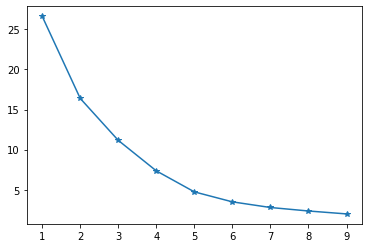

In [ ]:
plt.plot(range(1,10,1),inertia_vals,marker='*')
plt.show()

In [ ]:
for i in range(0,9,1):
  print("----------------------")
  print('cluster',n_cluster[i])
  print(clusters[i])
  print("Silhouette score: ", silhouette_score(vectorized_docs,clusters[i].predict(vectorized_docs)))

----------------------
cluster 2
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=5, tol=0.0001, verbose=0)
Silhouette score:  0.5382725164068034
----------------------
cluster 3
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=5, tol=0.0001, verbose=0)
Silhouette score:  0.5028481772131678
----------------------
cluster 4
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=5, tol=0.0001, verbose=0)
Silhouette score:  0.5062131948420939
----------------------
cluster 5
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=5, tol=0.0001, verbo

In [ ]:
k = 3

k_means = KMeans(n_clusters=k, random_state=5)
k_means.fit(vectorized_docs)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=5, tol=0.0001, verbose=0)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=5)

reduced_vectors = pca.fit_transform(vectorized_docs)
reduced_clusters = pca.fit_transform(k_means.cluster_centers_)

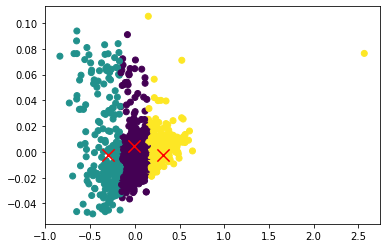

In [ ]:
plt.scatter(reduced_vectors[:,0],reduced_vectors[:,1],c=k_means.labels_)
plt.scatter(reduced_clusters[:, 0],reduced_clusters[:, 1], marker='x', s=150, c='r')

In [ ]:
df['preprocessed_abstract'] = abstract_list
df['labels'] = k_means.labels_
df['labels'].value_counts()

0    413
2    262
1    245
Name: labels, dtype: int64

In [ ]:
def get_top_n_words(corpus, n):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
def get_wordcloud(text):
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

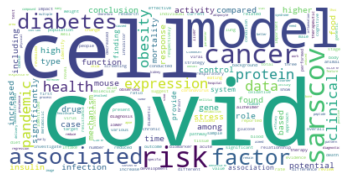

Top 10 words from cluster 0 :
['covid', 'cell', 'model', 'risk', 'sarscov', 'cancer', 'associated', 'factor', 'diabetes', 'expression']


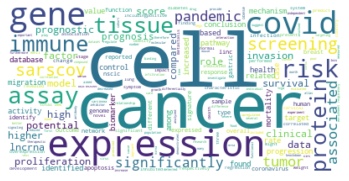

Top 10 words from cluster 1 :
['cell', 'cancer', 'expression', 'gene', 'covid', 'risk', 'assay', 'tissue', 'protein', 'immune']


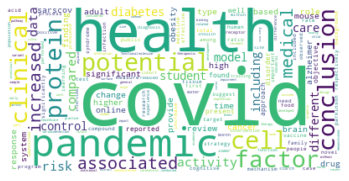

Top 10 words from cluster 2 :
['covid', 'health', 'pandemic', 'potential', 'cell', 'factor', 'conclusion', 'protein', 'clinical', 'associated']


In [ ]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
for clus in range (3):
    text =' '
    df2 = df.loc[df["labels"]==clus]
    
    #wordcloud
    for abst in df2.preprocessed_abstract:
        text += abst
    get_wordcloud(text)
    
    #top10words
    words = []
    for i, j in get_top_n_words(df2["preprocessed_abstract"],10):
        words.append(i)
    print ("Top 10 words from cluster",clus,":")
    print (words)